In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spectral
import spectral.io.envi as envi
import cv2

### 反射率へ変換
$R = ((I_{3.0} - D_{3.0}) / 3.0) / ((W_{2.5} - D_{2.5}) / 2.5)$
- R : 反射率スペクトル
- I : サンプルの反射強度スペクトル
- W : ホワイトボードの反射スペクトル
- D : Darkデータ（カメラのノイズ）

In [2]:
def load(name: str):
    dark30_intensity = envi.open(r"raw_data\dark.3.hdr", r"raw_data\dark.3.raw")
    dark25_intensity = envi.open(r"raw_data\dark.2.5.hdr", r"raw_data\dark.2.5.raw")
    white25_intensity = envi.open(r"raw_data\white_2.5.hdr", r"raw_data\white_2.5.raw")
    wood_intensity = envi.open(fr"raw_data\{name}.hdr", fr"raw_data\{name}.raw")

    D30 = np.array(dark30_intensity.load())
    D25 = np.array(dark25_intensity.load())
    W25 = np.array(white25_intensity.load())
    I30 = np.array(wood_intensity.load())

    wave =wood_intensity.metadata['wavelength']
    wave=np.array(wave,dtype=np.float32)

    mask = wave < 2200 # 2200 nm 以上をカット.
    D30 = D30[:, :, mask]
    D25 = D25[:, :, mask]
    W25 = W25[:, :, mask]
    I30 = I30[:, :, mask]

    R = ((I30 - D30)/3.0) / ((W25 - D25)/2.5)
    return R

### 複合的なモルフォロジー演算
> `cv2.erode`関数と`cv2.dilate`関数を組み合わせることで、さらに高度な処理が可能になります。
- Opening: 収縮 → 膨張の順に実行。ノイズ除去や細かい突起物の削除に適しています。
- Closing: 膨張 → 収縮の順に実行。小さな穴の埋め立てや輪郭の平滑化に適しています。
これらを組み合わせることで、細かなノイズを除去します。

In [3]:
def denoise(data):
    H, W, C = data.shape
    data_denoised = []
    kernel_3x3 = np.ones((3, 3), np.uint8)
    
    for i in range(C):
        band = (data[:, :, i] * 255).astype(np.uint8)
        denoised_band = cv2.dilate(cv2.erode(band, kernel_3x3), kernel_3x3)
        denoised_band = denoised_band.astype(np.float32) / 255.0
        data_denoised.append(denoised_band)
    
    return np.stack(data_denoised, axis=2)

### データ取得

In [4]:
def preprocessing(name: str):
    data = load(name)
    data_denoized = denoise(data)
    return data_denoized

In [5]:
name_list = ['s1', 's2_2_1', 's2_2_2', 's3', 's4_2_1', 's4_2_2']
data_list = []
for i in name_list:
    data_denoised = preprocessing(i)
    data_list.append(data_denoised)

c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\spectral\io\envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


### 木材マスクの作成

In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def bgmask(data):
    pca = PCA(n_components=1)
    km = KMeans(n_clusters=2, random_state=42)
    H, W, C = data.shape
    data_pca = pca.fit_transform(data.reshape(-1, C))
    label = km.fit_predict(data_pca).reshape(H, W)
    return label

c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn,

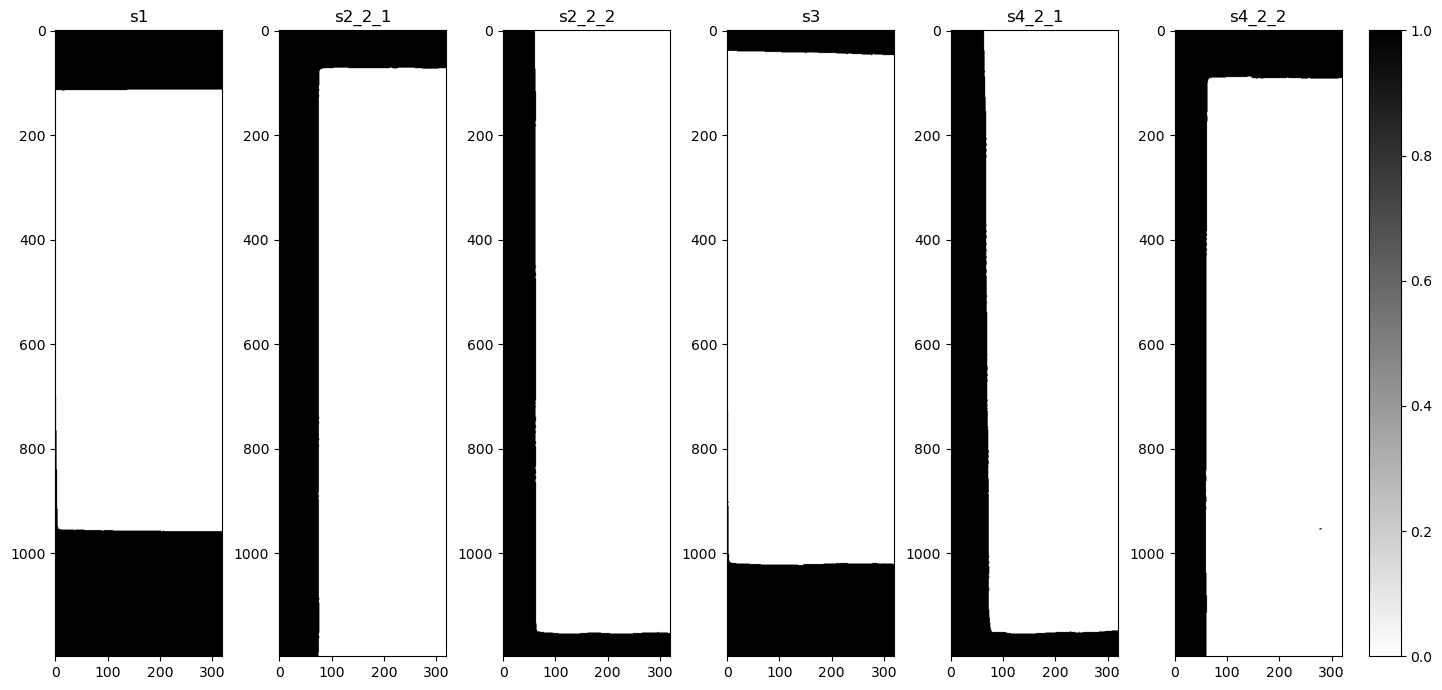

In [7]:
labels = []
fig, ax = plt.subplots(1, 6, figsize=(15, 7))
ax = ax.flatten()
for i, name, data in zip(np.arange(6), name_list, data_list):
    label = bgmask(data)
    labels.append(label)
    im = ax[i].imshow(label, cmap='binary')
    ax[i].set_title(fr'{name}')
plt.tight_layout(rect=[0, 0, 0.96, 1])
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)

### SNV処理

In [8]:
def snv(data):
    mean = data.mean(axis=2, keepdims=True)
    std = data.std(axis=2, ddof=1, keepdims=True)
    std[std == 0] = 1e-8 # 0 割り回避.
    return (data - mean) / std

In [9]:
data_snv_list = []
for data in data_list:
    data_snv_list.append(snv(data))

### 保存

- 波数の保存

In [10]:
wood_intensity = envi.open(r"raw_data\s1.hdr", r"raw_data\s1.raw")
wave =wood_intensity.metadata['wavelength']
wave=np.array(wave,dtype=np.float32)
mask = wave < 2200 
wave_cut = wave[mask]
wavenumber = 10**7 / wave_cut
np.save(r'Data_preprocessed\wavenumber.npy', wavenumber)

c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\spectral\io\envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


- 木材マスクとsnv処理したものを保存

In [11]:
for name, bgmask, img in zip(name_list, labels, data_snv_list):
    np.save(fr'Data_preprocessed\{name}_mask.npy', bgmask)
    np.save(fr'Data_preprocessed\{name}.npy', img)